# Decision Tree on Crime Prediction

## Read CSV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ai-project/

/content/drive/MyDrive/Colab Notebooks/ai-project


In [ ]:
crime = pd.read_csv('./NYPD_Complaint_Data_Historic.csv',
                    usecols=['CMPLNT_FR_DT', 'CMPLNT_FR_TM', # Time related features
                             'LAW_CAT_CD', # Crime description
                             'BORO_NM', 'ADDR_PCT_CD', 'PREM_TYP_DESC']) # Location related features
# Rename the columns
crime.columns = ['date', 'time', # Time related features
                 'level', # Crime description
                 'borough', 'precinct', 'premises'] # Location related features
crime

,date,time,level,borough,precinct,premises
0,12/31/2015,23:45:00,FELONY,BRONX,44.0,BAR/NIGHT CLUB
1,12/31/2015,23:36:00,FELONY,QUEENS,103.0,NaN
2,12/31/2015,23:30:00,FELONY,MANHATTAN,28.0,OTHER
3,12/31/2015,23:30:00,MISDEMEANOR,QUEENS,105.0,RESIDENCE-HOUSE
4,12/31/2015,23:25:00,MISDEMEANOR,MANHATTAN,13.0,OTHER
...,...,...,...,...,...,...
1048570,11/1/2013,20:30:00,MISDEMEANOR,BRONX,40.0,RESIDENCE - APT. HOUSE
1048571,11/1/2013,20:28:00,MISDEMEANOR,BROOKLYN,75.0,GROCERY/BODEGA
1048572,11/1/2013,20:25:00,FELONY,MANHATTAN,1.0,FAST FOOD
1048573,11/1/2013,20:25:00,MISDEMEANOR,BRONX,52.0,STREET


In [ ]:
raw_shape = crime.shape
raw_dtypes = crime.dtypes

def print_data_info(data):
  print("Original shape of data is", raw_shape)
  print("Current shape of data is", data.shape)
  print("-" * 50)
  print("Original shape of data is\n", raw_dtypes)
  print("Current shape of data is\n", data.dtypes)

In [ ]:
print_data_info(crime)

Original shape of data is (1048575, 6)
Current shape of data is (1048575, 6)
--------------------------------------------------
Original shape of data is
 date         object
time         object
level        object
borough      object
precinct    float64
premises     object
dtype: object
Current shape of data is
 date         object
time         object
level        object
borough      object
precinct    float64
premises     object
dtype: object


## Pre-process

### Process Data and Time

In [ ]:
# Transform data and time to datetime
crime.date = pd.to_datetime(crime.date, errors='coerce')
crime.time = pd.to_datetime(crime.time, errors='coerce').dt.hour
# Drop na date
crime.isna().sum()
crime.dropna(inplace=True)
# Transform time to int, where it only keeps hours
crime.time = crime.time.astype('int64')
crime.dtypes
# Drop too old date
crime = crime[(crime.date > '11-01-2013') & (crime.date < '01-01-2019')]
# crime = crime[(crime.date > '11-01-2013') & (crime.date < '12-01-2013')]
crime

,date,time,level,borough,precinct,premises
0,2015-12-31,23,FELONY,BRONX,44.0,BAR/NIGHT CLUB
2,2015-12-31,23,FELONY,MANHATTAN,28.0,OTHER
3,2015-12-31,23,MISDEMEANOR,QUEENS,105.0,RESIDENCE-HOUSE
4,2015-12-31,23,MISDEMEANOR,MANHATTAN,13.0,OTHER
5,2015-12-31,23,FELONY,BROOKLYN,71.0,DRUG STORE
...,...,...,...,...,...,...
1048041,2013-11-02,0,VIOLATION,BRONX,42.0,STREET
1048042,2013-11-02,0,MISDEMEANOR,BROOKLYN,73.0,RESIDENCE - APT. HOUSE
1048043,2013-11-02,0,MISDEMEANOR,BRONX,47.0,LIQUOR STORE
1048044,2013-11-02,0,FELONY,MANHATTAN,13.0,STREET


### Process Level

In [ ]:
# Transform level with one-hot encoding
from sklearn import preprocessing
encoder = preprocessing.OneHotEncoder()
levels = pd.DataFrame(encoder.fit_transform(crime[["level"]]).toarray(),
                      columns=encoder.categories_)
levels

,FELONY,MISDEMEANOR,VIOLATION
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
1032475,0.0,0.0,1.0
1032476,0.0,1.0,0.0
1032477,0.0,1.0,0.0
1032478,1.0,0.0,0.0


In [ ]:
# Replace the levle with FELONY
crime["level"] = levels["FELONY"].values
crime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,time,level,borough,precinct,premises
0,2015-12-31,23,1.0,BRONX,44.0,BAR/NIGHT CLUB
2,2015-12-31,23,1.0,MANHATTAN,28.0,OTHER
3,2015-12-31,23,0.0,QUEENS,105.0,RESIDENCE-HOUSE
4,2015-12-31,23,0.0,MANHATTAN,13.0,OTHER
5,2015-12-31,23,1.0,BROOKLYN,71.0,DRUG STORE
...,...,...,...,...,...,...
1048041,2013-11-02,0,0.0,BRONX,42.0,STREET
1048042,2013-11-02,0,0.0,BROOKLYN,73.0,RESIDENCE - APT. HOUSE
1048043,2013-11-02,0,0.0,BRONX,47.0,LIQUOR STORE
1048044,2013-11-02,0,1.0,MANHATTAN,13.0,STREET


## Sampling

In [ ]:
counts = crime["level"].value_counts()
print(counts)
probs = counts / len(crime)
print(probs)

0.0    712482
1.0    319998
Name: level, dtype: int64
0.0    0.690069
1.0    0.309931
Name: level, dtype: float64


In [ ]:
k_per_level = 100000 # Number of samples per group

In [ ]:
np.random.seed(1)
stratified_sample_counts_without_replacement = crime.groupby("level", group_keys=False)\
.apply(lambda x: x.sample(k_per_level, replace=False))
print("Counts:", len(stratified_sample_counts_without_replacement))
stratified_sample_counts_without_replacement

Counts: 200000


,date,time,level,borough,precinct,premises
461778,2015-01-16,1,0.0,BRONX,40.0,RESIDENCE - APT. HOUSE
867460,2014-03-22,16,0.0,BROOKLYN,68.0,GROCERY/BODEGA
952237,2014-01-14,17,0.0,QUEENS,110.0,RESIDENCE - APT. HOUSE
317404,2015-05-13,17,0.0,MANHATTAN,19.0,DEPARTMENT STORE
911359,2014-02-17,12,0.0,BROOKLYN,77.0,OTHER
...,...,...,...,...,...,...
167646,2015-08-26,23,1.0,BROOKLYN,61.0,STREET
433730,2015-02-10,3,1.0,MANHATTAN,34.0,RESIDENCE - PUBLIC HOUSING
595899,2014-09-30,20,1.0,MANHATTAN,24.0,STREET
805159,2014-05-07,23,1.0,BROOKLYN,75.0,STREET


In [ ]:
crime = stratified_sample_counts_without_replacement

### Process Location

In [ ]:
# Transform borough with one-hot encoding
borough = pd.DataFrame(encoder.fit_transform(crime[["borough"]]).toarray(),
                       columns=encoder.categories_)
borough

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
199995,0.0,1.0,0.0,0.0,0.0
199996,0.0,0.0,1.0,0.0,0.0
199997,0.0,0.0,1.0,0.0,0.0
199998,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Transform borough with one-hot encoding
precinct = pd.DataFrame(encoder.fit_transform(crime[["precinct"]]).toarray(),
                       columns=encoder.categories_)
precinct

,1.0,5.0,6.0,7.0,9.0,10.0,13.0,14.0,17.0,18.0,...,110.0,111.0,112.0,113.0,114.0,115.0,120.0,121.0,122.0,123.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transform premises with one-hot encoding
premises = pd.DataFrame(encoder.fit_transform(crime[["premises"]]).toarray(),
                        columns=encoder.categories_)
premises

,ABANDONED BUILDING,AIRPORT TERMINAL,ATM,BANK,BAR/NIGHT CLUB,BEAUTY & NAIL SALON,BOOK/CARD,BRIDGE,BUS (NYC TRANSIT),BUS (OTHER),...,TAXI (LIVERY LICENSED),TAXI (YELLOW LICENSED),TAXI/LIVERY (UNLICENSED),TELECOMM. STORE,TRAMWAY,TRANSIT - NYC SUBWAY,TRANSIT FACILITY (OTHER),TUNNEL,VARIETY STORE,VIDEO STORE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
crime.reset_index(drop=True, inplace=True)
crime = crime.drop(columns=["borough", "premises"])
# crime = pd.concat([crime, borough, premises], axis=1)
crime = pd.concat([crime, borough, precinct, premises], axis=1)
crime

,date,time,level,precinct,"(BRONX,)","(BROOKLYN,)","(MANHATTAN,)","(QUEENS,)","(STATEN ISLAND,)","(1.0,)",...,"(TAXI (LIVERY LICENSED),)","(TAXI (YELLOW LICENSED),)","(TAXI/LIVERY (UNLICENSED),)","(TELECOMM. STORE,)","(TRAMWAY,)","(TRANSIT - NYC SUBWAY,)","(TRANSIT FACILITY (OTHER),)","(TUNNEL,)","(VARIETY STORE,)","(VIDEO STORE,)"
0,2015-01-16,1,0.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-03-22,16,0.0,68.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-14,17,0.0,110.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-13,17,0.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-02-17,12,0.0,77.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2015-08-26,23,1.0,61.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,2015-02-10,3,1.0,34.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,2014-09-30,20,1.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,2014-05-07,23,1.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print_data_info(crime)

Original shape of data is (1048575, 6)
Current shape of data is (200000, 156)
--------------------------------------------------
Original shape of data is
 date         object
time         object
level        object
borough      object
precinct    float64
premises     object
dtype: object
Current shape of data is
 date                           datetime64[ns]
time                                    int64
level                                 float64
precinct                              float64
(BRONX,)                              float64
                                    ...      
(TRANSIT - NYC SUBWAY,)               float64
(TRANSIT FACILITY (OTHER),)           float64
(TUNNEL,)                             float64
(VARIETY STORE,)                      float64
(VIDEO STORE,)                        float64
Length: 156, dtype: object


## Decision Tree

In [ ]:
# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
# Cross-validation randomly divides the data into a training set and a test set
# The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.
from sklearn.model_selection import cross_val_score
from sklearn import tree
initial = crime
initial.date = initial.date.dt.dayofweek
# start it up!
# Here the maximum depth is 3, which refers to the height of the tree
clf = tree.DecisionTreeClassifier(criterion="gini",random_state=30,splitter="random"
                                  ,max_depth=3
                                  ,min_samples_leaf=10 
                                  ,min_samples_split=10)
# fit it!
# The decision tree takes two array inputs, x (initial) and y, where x is the training set and y is the class labels of the training set

# Partition the test set (where Y is finally put into the model)
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(initial, train_size=0.75)
Y = x_train['level']
x_train = x_train.drop('level', 1)

clf = clf.fit(x_train, Y)
# actually, we have a tree here, but we still need a visulization
initial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


,date,time,level,precinct,"(BRONX,)","(BROOKLYN,)","(MANHATTAN,)","(QUEENS,)","(STATEN ISLAND,)","(1.0,)",...,"(TAXI (LIVERY LICENSED),)","(TAXI (YELLOW LICENSED),)","(TAXI/LIVERY (UNLICENSED),)","(TELECOMM. STORE,)","(TRAMWAY,)","(TRANSIT - NYC SUBWAY,)","(TRANSIT FACILITY (OTHER),)","(TUNNEL,)","(VARIETY STORE,)","(VIDEO STORE,)"
0,4,1,0.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,16,0.0,68.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,17,0.0,110.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,17,0.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,12,0.0,77.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2,23,1.0,61.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,1,3,1.0,34.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,1,20,1.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,2,23,1.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target = x_test['level']
x_test = x_test.drop('level', 1)
pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred , target)
print(acc)

0.52126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
pos_label = 1
print(classification_report(pred, target))

              precision    recall  f1-score   support

         0.0       0.07      0.72      0.12      2292
         1.0       0.97      0.51      0.67     47708

    accuracy                           0.52     50000
   macro avg       0.52      0.61      0.40     50000
weighted avg       0.93      0.52      0.65     50000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


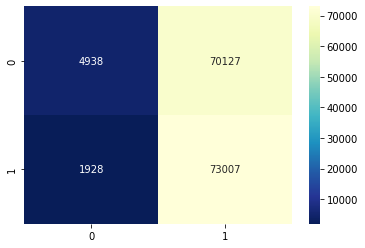

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_on_train = clf.predict(x_train)
cm = confusion_matrix(Y,pred_on_train)

sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

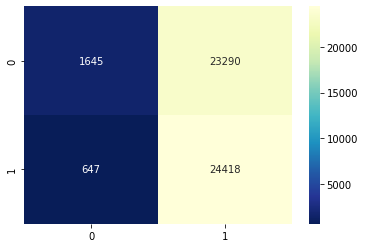

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = target
y_pred = pred
cm = confusion_matrix(y_true,y_pred)

sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


['date', 'time', 'precinct', ('BRONX',), ('BROOKLYN',), ('MANHATTAN',), ('QUEENS',), ('STATEN ISLAND',), (1.0,), (5.0,), (6.0,), (7.0,), (9.0,), (10.0,), (13.0,), (14.0,), (17.0,), (18.0,), (19.0,), (20.0,), (22.0,), (23.0,), (24.0,), (25.0,), (26.0,), (28.0,), (30.0,), (32.0,), (33.0,), (34.0,), (40.0,), (41.0,), (42.0,), (43.0,), (44.0,), (45.0,), (46.0,), (47.0,), (48.0,), (49.0,), (50.0,), (52.0,), (60.0,), (61.0,), (62.0,), (63.0,), (66.0,), (67.0,), (68.0,), (69.0,), (70.0,), (71.0,), (72.0,), (73.0,), (75.0,), (76.0,), (77.0,), (78.0,), (79.0,), (81.0,), (83.0,), (84.0,), (88.0,), (90.0,), (94.0,), (100.0,), (101.0,), (102.0,), (103.0,), (104.0,), (105.0,), (106.0,), (107.0,), (108.0,), (109.0,), (110.0,), (111.0,), (112.0,), (113.0,), (114.0,), (115.0,), (120.0,), (121.0,), (122.0,), (123.0,), ('ABANDONED BUILDING',), ('AIRPORT TERMINAL',), ('ATM',), ('BANK',), ('BAR/NIGHT CLUB',), ('BEAUTY & NAIL SALON',), ('BOOK/CARD',), ('BRIDGE',), ('BUS (NYC TRANSIT)',), ('BUS (OTHER)',), 

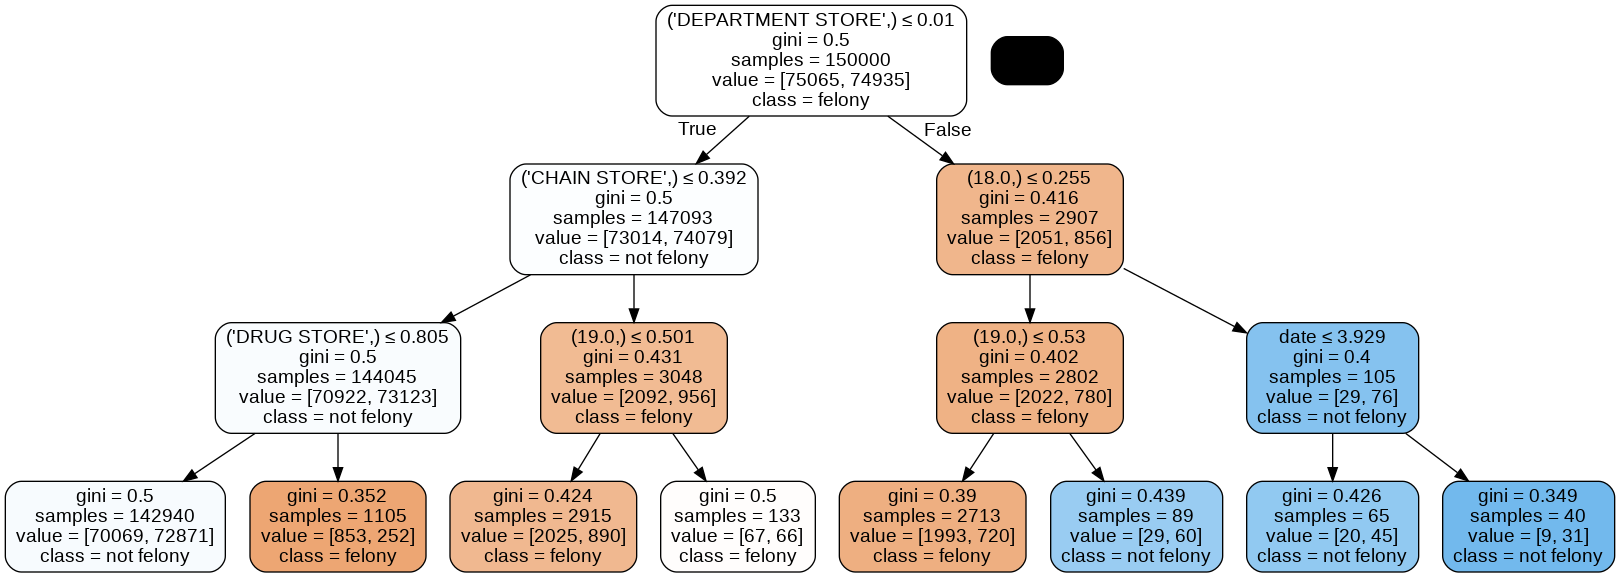

In [ ]:
# DTree visualization
y_pred = clf.predict(x_test)
list(x_test)
feature_name=list(x_test)
print(feature_name)
import pydotplus 
from IPython.display import Image 
classname=['felony',"not felony"]
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(x_test),  
                         class_names=classname,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

### Use alternative data to complete the DT

In [ ]:
# Use an alternative csv data
alter = pd.read_csv('./communities-crime-clean.csv')
alter

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,Alabastercity,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0.06
1,1,AlexanderCitycity,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,0.14
2,1,Annistoncity,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1.00
3,1,Athenscity,8,0.01,0.38,0.35,0.71,0.04,0.01,0.39,...,0.03,0.78,0.56,0.67,0.71,0.09,0.05,0.00,0.0,0.23
4,1,Auburncity,1,0.04,0.37,0.32,0.70,0.21,0.02,1.00,...,0.12,0.49,0.12,0.00,0.15,0.09,0.09,0.01,0.0,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,56,Gillettecity,9,0.01,0.53,0.00,0.96,0.02,0.06,0.47,...,0.01,0.32,0.34,0.56,0.55,0.04,0.11,0.11,0.0,0.15
1989,56,GreenRivercity,9,0.00,0.67,0.01,0.91,0.03,0.21,0.56,...,0.06,0.35,0.55,0.70,0.58,0.03,0.09,0.77,0.0,0.06
1990,56,Laramiecity,3,0.03,0.40,0.02,0.90,0.14,0.12,0.89,...,0.10,0.37,0.24,0.18,0.34,0.03,0.20,0.02,0.0,0.12
1991,56,RockSpringscity,7,0.01,0.45,0.02,0.92,0.06,0.14,0.48,...,0.05,0.46,0.59,0.75,0.71,0.05,0.09,0.32,0.0,0.27


In [ ]:
alter['crime_severity'] = np.where(alter['ViolentCrimesPerPop']>0.1, 1, 0)
# Count the precentage
counts = alter["crime_severity"].value_counts()
print(counts)
probs = counts / len(alter)
print(probs)

1    1250
0     743
Name: crime_severity, dtype: int64
1    0.627195
0    0.372805
Name: crime_severity, dtype: float64


In [ ]:
# Stratefied Sampling
np.random.seed(1)
alter_samples = alter.groupby("crime_severity", group_keys=False)\
.apply(lambda x: x.sample(500, replace=False))
print("Counts:", len(alter_samples))
alter_samples = alter_samples.drop('communityname', 1) # Cannot use
alter_samples = alter_samples.drop('ViolentCrimesPerPop', 1) # Not related
alter_samples = alter_samples.drop('fold', 1) # Cannot use
alter_samples = alter_samples.drop('state', 1) # Samples are not enough
alter_samples 

Counts: 1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,crime_severity
969,0.01,0.47,0.03,0.93,0.19,0.03,0.24,0.31,0.15,0.37,...,0.21,0.49,0.48,0.23,0.52,0.07,0.06,0.33,0.00,0
1277,0.04,0.34,0.02,0.94,0.04,0.01,0.49,0.55,0.39,0.44,...,0.06,0.74,0.51,0.59,0.66,0.04,0.22,0.02,0.00,0
1498,0.00,0.50,0.02,0.98,0.02,0.00,0.53,0.44,0.35,0.48,...,0.03,0.97,0.81,0.84,0.85,0.13,0.02,0.01,0.00,0
1467,0.01,0.24,0.03,0.97,0.02,0.01,0.37,0.46,0.31,0.64,...,0.05,0.96,0.63,0.86,0.89,0.01,0.49,0.04,0.00,0
1974,0.01,0.48,0.01,0.98,0.03,0.02,0.41,0.50,0.28,0.29,...,0.03,0.80,0.47,0.64,0.70,0.02,0.18,0.01,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.08,0.49,1.00,0.00,0.13,0.19,0.45,0.55,0.35,0.28,...,0.59,0.50,0.59,0.75,0.66,0.01,1.00,1.00,0.19,1
400,0.21,0.47,0.52,0.37,0.14,0.49,0.42,0.56,0.36,0.43,...,0.43,0.51,0.51,0.81,0.66,0.04,0.74,0.36,0.63,1
540,0.00,0.34,0.02,0.97,0.06,0.03,0.22,0.24,0.11,0.92,...,0.16,0.16,0.21,0.15,0.17,0.03,0.07,0.00,0.00,1
1784,0.00,0.49,0.07,0.83,0.09,0.33,0.41,0.48,0.29,0.27,...,0.12,0.48,0.45,0.27,0.62,0.06,0.04,0.01,0.00,1


In [ ]:
# Split the sets
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(alter_samples, train_size=0.8)
y_train = x_train['crime_severity']
x_train = x_train.drop('crime_severity', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
# Fit the tree
from sklearn.model_selection import cross_val_score
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train, y_train)
clf

DecisionTreeClassifier(max_depth=3)

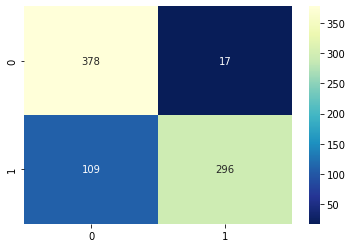

In [ ]:
# Print the matrix for training sets
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_on_train = clf.predict(x_train)
cm = confusion_matrix(y_train,y_pred_on_train)

sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


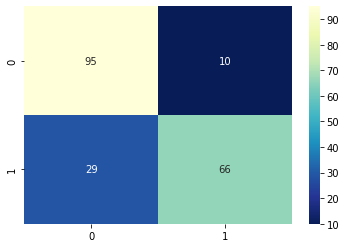

In [ ]:

y_test = x_test['crime_severity']
x_test = x_test.drop('crime_severity', 1)
# Print the matrix for testing set
y_pred_on_test = clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred_on_test)

sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
pos_label = 1
print(classification_report(y_test, y_pred_on_test))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       105
           1       0.87      0.69      0.77        95

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

